In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
!pip install wget
import wget
import os

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=e89dba31cc29380c548466d96b80f8746611ba7981f2830fc063fc30f1574db0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
# https://labs.wesleycota.com/sarscov2/br
# http://plataforma.saude.gov.br/novocoronavirus/#COVID-19-brazil
# https://covid19br.github.io/index.html
# tabela :: wget -r https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv
# 412 mil leitos o BRasil. 1,95 por mi hab (https://super.abril.com.br/saude/grafico-a-quantidade-de-leitos-hospitalares-ao-redor-do-mundo/)
# wget -r https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv

url ="https://s3-us-west-1.amazonaws.com/starschema.covid/JHU_COVID-19.csv"
output_directory = "/content"
# os.remove("/content/JHU_COVID-19.csv")
filename = wget.download(url, out=output_directory)
filename

# importa os dados usando pandas e trasforma em dataFrame
data = pd.read_csv(filename,header=0)
# dates = pd.read_csv("/content/cases-brazil-states.csv",header=0,index_col="date")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Total de casos: 1.128 (18 mortes*) 21 março 2020
# Total de casos: 1.546 (25 mortes*) 22 março 2020
# Total de casos: 1.891 (34 mortes*) 22 março 2020
# Total de casos: 2006 (34 mortes*) 24 março 2020
# Total de casos: 2452 (57 mortes*) 25 março 2020
# Total de casos: 2992 (77 mortes*) 27 março 2020

cfm = np.array([(18/1128.),(25/1546.), (34/1891.),(46/2201.),(57/2452.),(77/2992.),(114/3904.)])
cfm*100.

array([1.59574468, 1.61707633, 1.79799048, 2.08995911, 2.32463295,
       2.57352941, 2.92008197])

In [0]:
data.Date = pd.to_datetime(data.Date)
# seleciona os dados do Brasil
br = data[data["Country/Region"] == "Brazil"]
# seleciona os dados do Argentina
ar = data[data["Country/Region"] == "Argentina"]
# seleciona os dados do Uruguay
uy = data[data["Country/Region"] == "Uruguay"]
# seleciona os dados do Italia
ita = data[data["Country/Region"] == "Italy"]
# seleciona os dados da China
china = data[data["Country/Region"] == "China"]
# seleciona os dados da Peru
peru = data[data["Country/Region"] == "Peru"]

In [5]:
data["Case_Type"].unique()

array(['Confirmed', 'Deaths', 'Recovered', 'Active'], dtype=object)

23


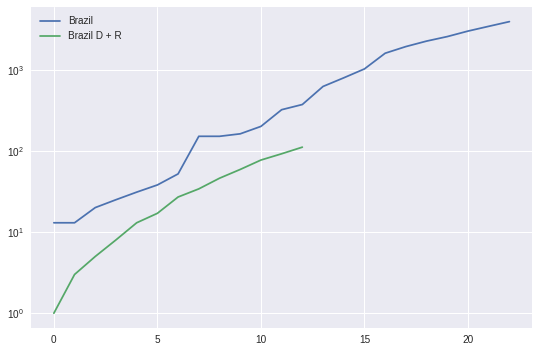

In [39]:
for k in ["Brazil"]:

  ndata = data.where(data["Country/Region"] == k).where(data["Case_Type"]=="Confirmed").where(data["Cases"]>10).groupby("Date").sum()
  rndata = data.where(data["Country/Region"] == k).where((data["Case_Type"]=="Deaths" )|(data["Case_Type"]=="Recovered") ).where(data["Cases"]>0).groupby("Date").sum()
  plt.plot(ndata["Cases"].values, label=k)
  plt.plot(rndata["Cases"].values, label=k+" D + R")
# plt.ylim(0.1,200)
plt.yscale("log")

# plt.xlim(pd.to_datetime("2020-03-01"),str(datetime.now().date()))
plt.legend()
print(len(ndata.Cases))

In [0]:
# seleciona somente casos confirmados no Brasil
confirmadosbr = br[br["Case_Type"] == "Confirmed"]
# ativos = br[br["Case_Type"] == "Active"]
timebr = confirmadosbr["Date"]

In [8]:
# confirmadosbr["Date"]
cond_idx = confirmadosbr.index[np.where(confirmadosbr["Cases"]>0)]

confirmadosbr["Date"][cond_idx[0]]
# confirmadosbr.index
timebr

1830    2020-01-22
1831    2020-01-23
1832    2020-01-24
1833    2020-01-25
1834    2020-01-26
           ...    
72725   2020-03-24
72726   2020-03-25
72727   2020-03-26
72728   2020-03-27
72729   2020-03-28
Name: Date, Length: 67, dtype: datetime64[ns]

In [0]:
# modifica os dados para utilizar no curve fit
xtime=[]
ydata=[]
xtimebr=[]
ydatabr=[]
dia=[]
today=datetime.now().date()
################################### quantidade de casos #####
cond_idx = confirmadosbr.index[np.where(confirmadosbr["Cases"]>0)]
case1 = pd.to_datetime(confirmadosbr["Date"][cond_idx[0]])
########################################
for ib in enumerate(timebr):
  # somente dias onde o numero de casos confirmados é maior que 0
  # para o Brasil
  if confirmadosbr["Cases"][confirmadosbr.index[ib[0]]] > 0:
    # procura os dias..
    # print(ib[1])
    selday = (ib[1]-case1).days == np.arange(0,32,3)
    # a cada dois dias pegamos o numero de casos e convete o dia para dia inteiro
    if True in selday:
      xtimebr.append((ib[1]-case1).days)
      ydatabr.append(confirmadosbr["Cases"][confirmadosbr.index[ib[0]]])
      dia.append(timebr[confirmadosbr.index[ib[0]]])

# dados selecionador para fazer o ajsute
ydatabr = np.array(sorted(ydatabr))
xdatabr = np.array(sorted(xtimebr))
for i in range(5):
  dia.append(dia[-1]+timedelta(days=1))

In [10]:
# ajuste exponencial com a func, dos dasos xdata e ydata Brasil
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(b * x) + c
# popt2, pcov2 = curve_fit(func, xdata, ydata)
# erro no s coeficeintes
# perr2 = np.sqrt(np.diag(pcov2))
# Brasil
poptbr, pcovbr = curve_fit(func, xdatabr, ydatabr)
perrbr = np.sqrt(np.diag(pcovbr))
poptbr

array([ 11.10533999,   0.1928178 , -81.34029644])

Model SIER
https://github.com/XuelongSun/Dynamic-Model-of-Infectious-Diseases/blob/master/SIR.ipynb

In [0]:
# population
N = 1e4
# simuation Time / Day
T = 170
# susceptiable ratio
s = np.zeros([T])
# infective ratio
i = np.zeros([T])
# remove ratio >> isolate or deaths
r = np.zeros([T])

# contact rate
lamda = 0.1928
lamda = poptbr[1]
# recover rate tx mortos tx recuperados
gamma = 0.028432

# initial infective people
i[0] = 1.0 / N
r[0] = 0.0 / N
s[0] = N / N - r[0] - i[0]

for t in range(T-1):
    i[t + 1] = i[t] + i[t] * lamda * s[t] - gamma*i[t]
    s[t + 1] = s[t] - lamda * s[t] * i[t]
    r[t + 1] = r[t] + gamma*i[t]

In [12]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

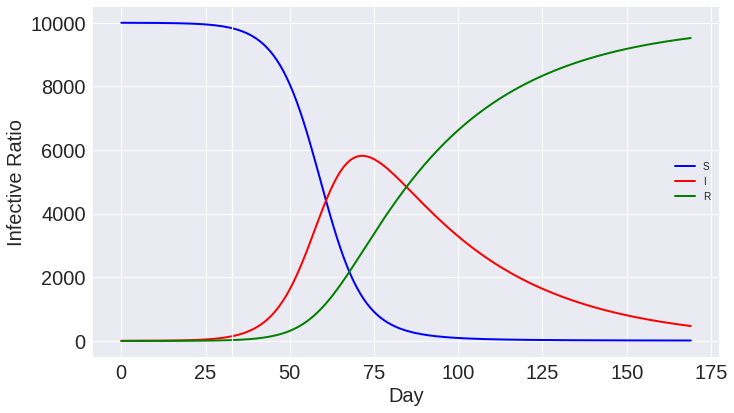

In [20]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(s*N, c='b', lw=2, label='S')
ax.plot(i*N, c='r', lw=2, label='I')
ax.plot(r*N, c='g', lw=2, label='R')
ax.axvline(3*len(xdatabr),lw=1.2)
ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Infective Ratio', fontsize=20)
ax.grid(1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend();

In [15]:
# Brasil utlizando a funçao para obeter a previsao
# for i in range(5):
#   dia.append(dia[-1]+timedelta(days=1))
# dados do fit no ajuste
brdata = func(xdatabr, *poptbr)
# prediacao 5 dias
prbrxdata = np.arange(xdatabr.max(),xdatabr.max()+6)
prbrdata = func(prbrxdata, *poptbr)
supEprbr = func(prbrxdata, *(poptbr+perrbr))
infEprbr = func(prbrxdata, *(poptbr-perrbr))

dprevisto = (today-case1.date()).days
su = func(dprevisto, *(poptbr+perrbr))
inf= func(dprevisto, *(poptbr-perrbr))
vabr = (su-inf)/2
hojebr = (func(dprevisto, *poptbr))
# dia_anterior = (func(-1, *poptbr))
print("hoje "+str(today)+" o numero de casos no Brasil será :: ",str(inf)[:7]," no melhor dos casos")
print("hoje "+str(today)+" o numero de casos no Brasil será :: ",str(su)[:7]," no pior dos casos")
print("hoje "+str(today)+" o numero de casos no Brasil esperado será :: ",str(hojebr)[:7])

hoje 2020-03-29 o numero de casos no Brasil será ::  1177.36  no melhor dos casos
hoje 2020-03-29 o numero de casos no Brasil será ::  14805.5  no pior dos casos
hoje 2020-03-29 o numero de casos no Brasil esperado será ::  5229.98


In [0]:
today
case1.date()

datetime.date(2020, 2, 26)

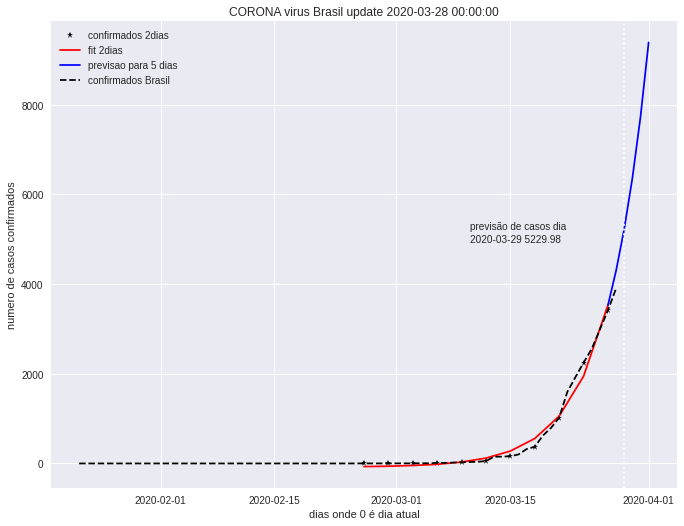

In [22]:
# Brasil grafico
fig = plt.figure(figsize=[10,8])
ax2 = plt.subplot()

ax2.plot(dia[:len(ydatabr)],ydatabr,"k*",label="confirmados 2dias")
ax2.plot(dia[:len(brdata)],brdata,"r+-",label="fit 2dias")
ax2.plot(dia[len(ydatabr)-1:],prbrdata,"b+-",label="previsao para 5 dias")
ax2.plot(timebr,confirmadosbr["Cases"],"k--",label="confirmados Brasil")
# # ax2.plot(xdatabr,brdata,"r+-",label="fit 2dias")
# ax2.plot(prbrxdata,prbrdata,"b+-",label="previsao para 5 dias")
# ax2.plot(pr2xdata,supEprbr,"gray",lw=0.8,label="incerteza da previsao")
# ax2.plot(pr2xdata,infEprbr,"gray",lw=0.8)
# ax2.text(-8,hojebr,"previsão de casos dia ")
# ax2.text(-8,hojebr-150,str(datetime.now().date())+" "+str(hojebr)[:7])
# # ax2.text(-5,hojebr-100,"variaçao de "+str(vabr)[:7])
ax2.text("2020-03-10",hojebr,"previsão de casos dia ")
ax2.text("2020-03-10",hojebr-300,str(datetime.now().date())+" "+str(hojebr)[:7])
# ax2.plot(timebr[timebr.index[-1]],ultimodia,"*")
ax2.axvline(today,ls="dotted",lw=1.8)

ax2.set_title("CORONA virus Brasil update "+str(br["Date"][br.index[-1]]))
ax2.set_xlabel("dias onde 0 é dia atual")
ax2.set_ylabel("numero de casos confirmados")
# ax2.set_xlim(-25,) #; ax1.set_ylim(0,2500)
# ax2.set_xlim("2020-03-01",datetime.now().date()+timedelta(days=5))
ax2.legend()
ax2.grid(1)
plt.show()

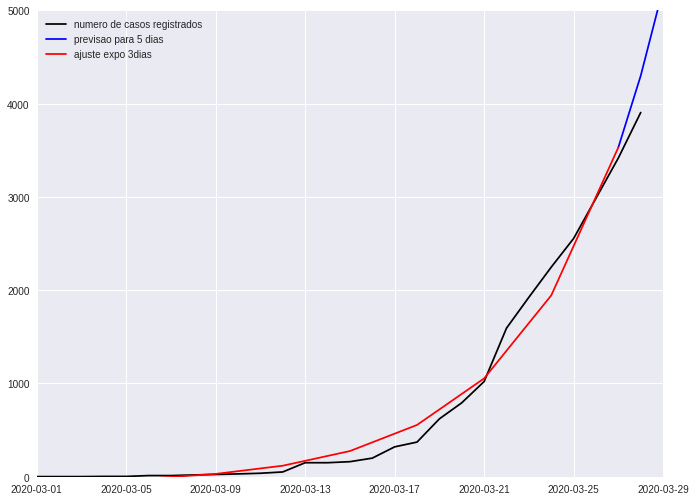

In [25]:
fig = plt.figure(figsize=[10,8])
plt.plot(timebr,confirmadosbr["Cases"],"k",label="numero de casos registrados")
plt.plot(dia[-len(prbrdata):],prbrdata,"b+-",label="previsao para 5 dias")
plt.plot(dia[:-5],brdata,"r",label="ajuste expo 3 dias")
plt.xlim("2020-03-01",datetime.now().date())
plt.ylim(0,5000)
plt.legend(loc=2)

plt.grid(1)
plt.show()

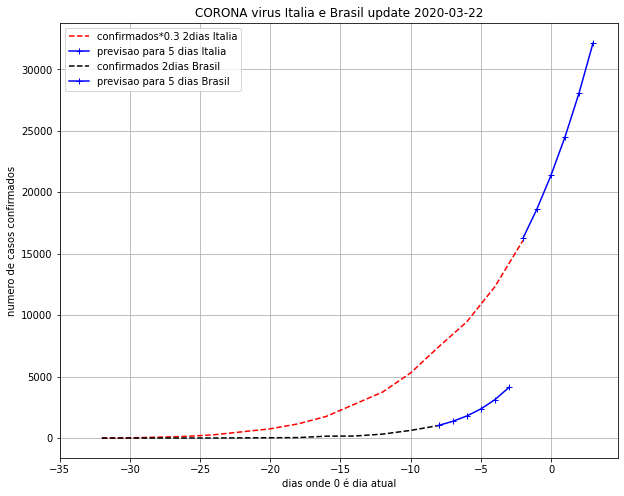

In [0]:
fig = plt.figure(figsize=[10,8])
ax1 = plt.subplot()
ax1.plot(xdata,np.array(ydata)*0.3,"r--",label="confirmados*0.3 2dias Italia")
ax1.plot(pr2xdata,np.array(pr2data)*0.3,"b+-",label="previsao para 5 dias Italia")

ax1.plot(np.array(xdatabr)-6,ydatabr,"k--",label="confirmados 2dias Brasil")
ax1.plot(np.array(prbrxdata)-6,prbrdata,"b+-",label="previsao para 5 dias Brasil")


ax1.set_title("CORONA virus Italia e Brasil update "+ita["Date"][ita.index[-1]])
ax1.set_xlabel("dias onde 0 é dia atual")

ax1.set_ylabel("numero de casos confirmados")

ax1.set_xlim(-35,) #; ax1.set_ylim(0,1000)

ax1.legend()

ax1.grid()

plt.show()